**Importing required Libreries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
%pip install wordcloud

In [ ]:
#Load the data
data = pd.read_csv(r"/content/amazon_alexa.tsv", delimiter = '\t', quoting = 3)
print(f'Dataset shape : {data.shape}')


Dataset shape : (3150, 5)


In [ ]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [ ]:
#columns names
print(f"Feature names : {data.columns.values}")


Feature names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [ ]:
#check for null values
data.isnull().sum()

,0
rating,0
date,0
variation,0
verified_reviews,1
feedback,0


there is one record with no 'verified_reviews'

In [ ]:
#getting the record where verified_reviews is null
data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [ ]:
#drop the null record
data.dropna(inplace=True)


In [ ]:
print(f"Dataset shape after dropping null value : {data.shape}")


Dataset shape after dropping null value : (3149, 5)


In [ ]:
#length of verified_reviews
data['length']= data['verified_reviews'].apply(len)

In [ ]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [ ]:
print(f"'verified_reviews' column value: {data.iloc[10]['verified_reviews']}")
print(f"length of review : {len(data.iloc[10]['verified_reviews'])}")
print(f"'length' column value : {data.iloc[10]['length']}")

'verified_reviews' column value: "I sent it to my 85 year old Dad, and he talks to it constantly."
length of review : 65
'length' column value : 65


length of reviews is same

datatypes of the features

In [ ]:
data.dtypes

,0
rating,int64
date,object
variation,object
verified_reviews,object
feedback,int64
length,int64


In [ ]:
print(f"rating value count: \n{data['rating'].value_counts()}")

rating value count: 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


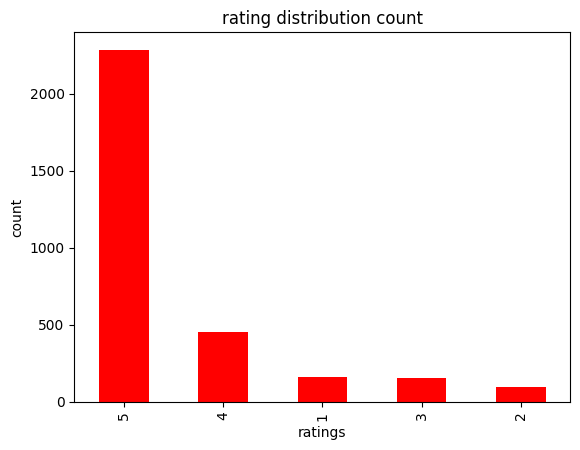

In [ ]:
#bar plot
data['rating'].value_counts().plot.bar(color = 'red')
plt.title('rating distribution count')
plt.xlabel('ratings')
plt.ylabel('count')
plt.show()

In [ ]:
#find percentage distribution of each rating
print(f"rating value count - percentage distribution: \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

rating value count - percentage distribution: 
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


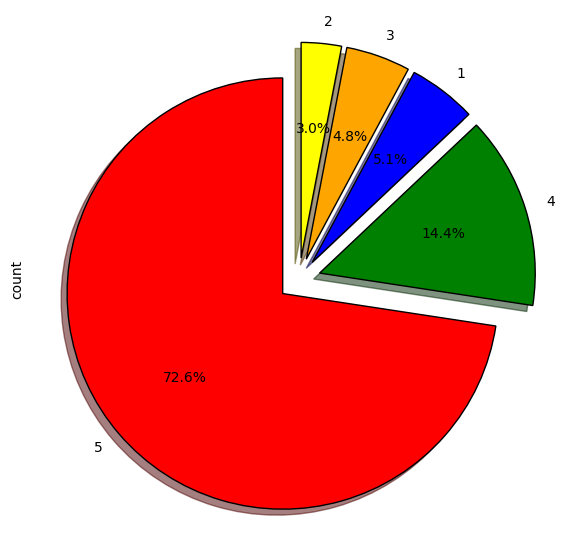

In [ ]:
import matplotlib.pyplot as plt
from io import BytesIO

fig = plt.figure(figsize=(7, 7))
colors = ('red', 'green', 'blue', 'orange', 'yellow')

wp = {'linewidth': 1, 'edgecolor': 'black'}
tags = data['rating'].value_counts() / data.shape[0]
explode = (0.1,) * len(tags)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, labels=tags.index)


graph = BytesIO()
fig.savefig(graph, format="png")


plt.show()


In [ ]:
#distinct values of feedback and is count
print(f"feedback value count: \n{data['feedback'].value_counts()}")


feedback value count: 
feedback
1    2893
0     256
Name: count, dtype: int64


In [ ]:
#extracting the verified_reviews value for one record with feedback =1
review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)


Loved it!


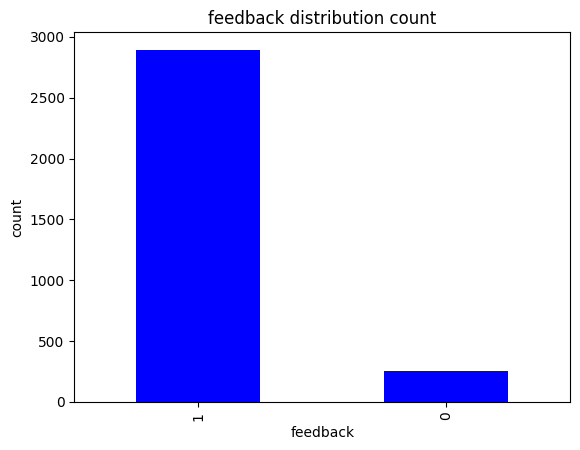

In [ ]:
#bar graph

data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('feedback distribution count')
plt.xlabel('feedback')
plt.ylabel('count')
plt.show()

In [ ]:
print(f"feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

feedback value count - percentage distribution: 
feedback
1    91.87
0     8.13
Name: count, dtype: float64


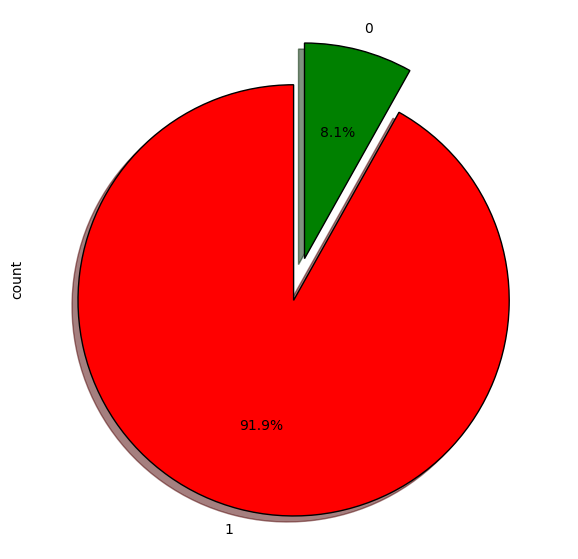

In [ ]:
import matplotlib.pyplot as plt
from io import BytesIO

fig = plt.figure(figsize=(7, 7))
colors = ('red', 'green')
wp = {'linewidth': 1, 'edgecolor': 'black'}
tags = data['feedback'].value_counts() / data.shape[0]
explode = (0.1, 0.1)

# Corrected labels argument
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, labels=tags.index)

# Create BytesIO object
graph = BytesIO()
fig.savefig(graph, format="png")

# Optionally display the plot
plt.show()


In [ ]:
data[data['feedback']==0]['rating'].value_counts()

,count
rating,
1,161
2,95


In [ ]:
data[data['feedback']==1]['rating'].value_counts()


,count
rating,
5,2286
4,455
3,152


In [ ]:
#distinct values of variation and its count
print(f"variation value count: \n{data['variation'].value_counts()}")

variation value count: 
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


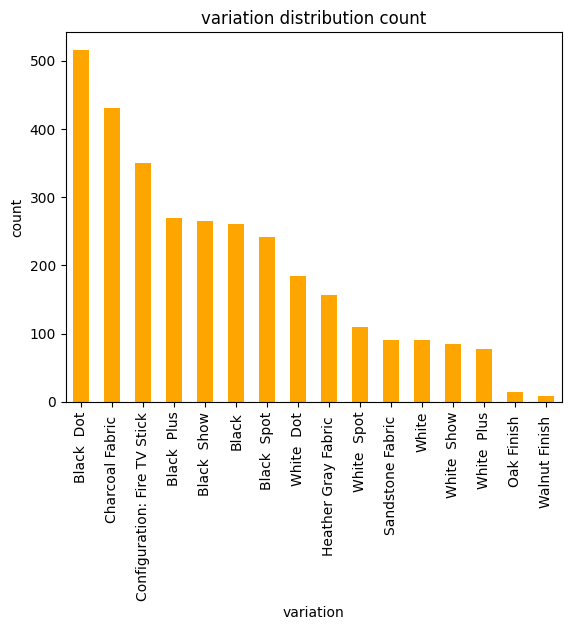

In [ ]:
data['variation'].value_counts().plot.bar(color = 'orange')
plt.title('variation distribution count')
plt.xlabel('variation')
plt.ylabel('count')
plt.show()

In [ ]:
print(f"Variation value count - percentage distribution: \n{round(data['variation'].value_counts() / data.shape[0] * 100, 2)}")


Variation value count - percentage distribution: 
variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


In [ ]:
data.groupby('variation')['rating'].mean()

,rating
variation,
Black,4.233716
Black Dot,4.453488
Black Plus,4.370370
Black Show,4.490566
Black Spot,4.311203
Charcoal Fabric,4.730233
Configuration: Fire TV Stick,4.591429
Heather Gray Fabric,4.694268
Oak Finish,4.857143


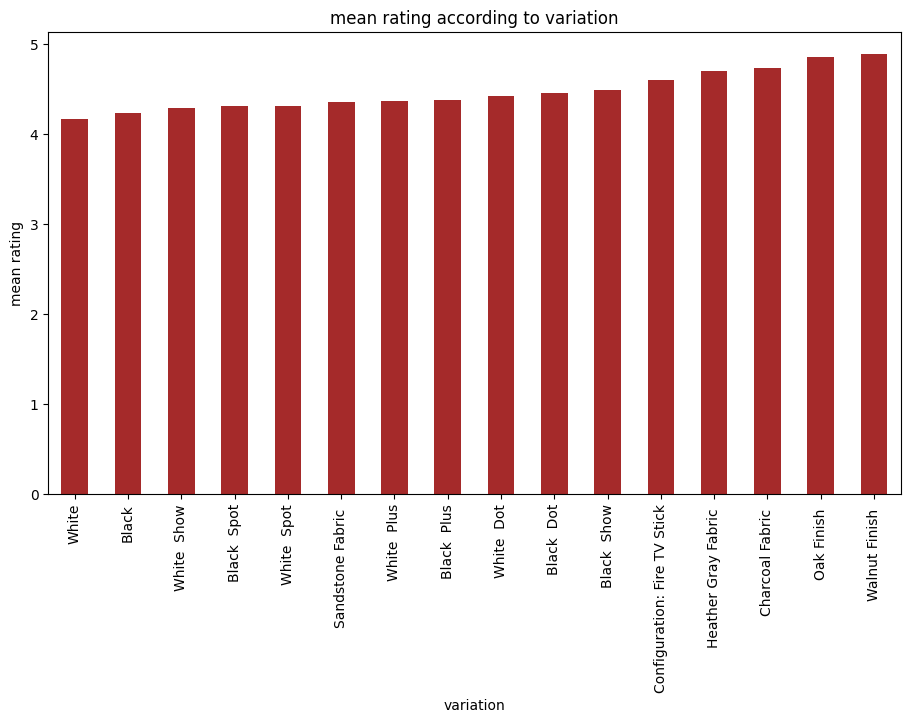

In [ ]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color='brown',figsize=(11,6))
plt.title('mean rating according to variation')
plt.xlabel('variation')
plt.ylabel('mean rating')
plt.show()

In [ ]:
data['length'].describe()


,length
count,3149.000000
mean,132.714513
std,182.541531
min,1.000000
25%,30.000000
50%,74.000000
75%,166.000000
max,2853.000000


[Text(0.5, 1.0, 'distribution of length of review')]

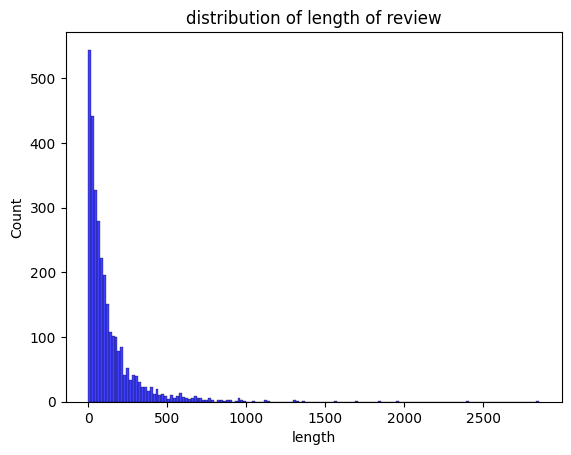

In [ ]:
sns.histplot(data['length'],color='blue').set(title='distribution of length of review')


[Text(0.5, 1.0, 'distribution of length of review if feedback = 0')]

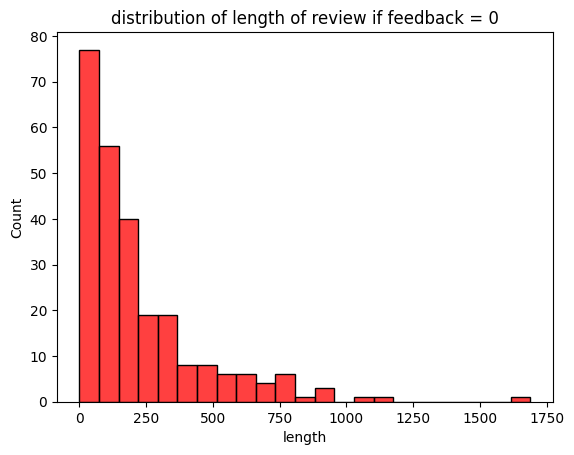

In [ ]:
 sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='distribution of length of review if feedback = 0')

[Text(0.5, 1.0, 'distribution of length of review if feedback = 1')]

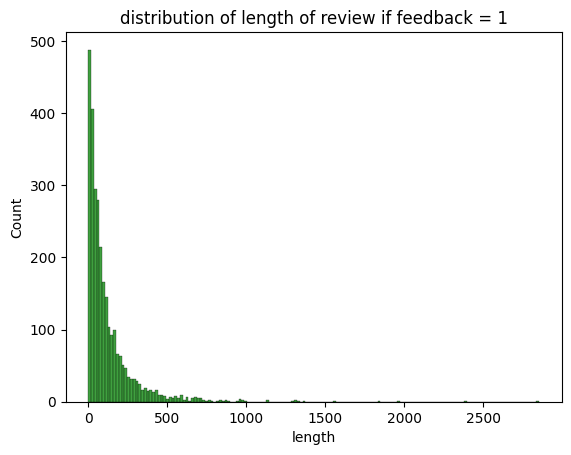

In [ ]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title='distribution of length of review if feedback = 1')

<Axes: ylabel='Frequency'>

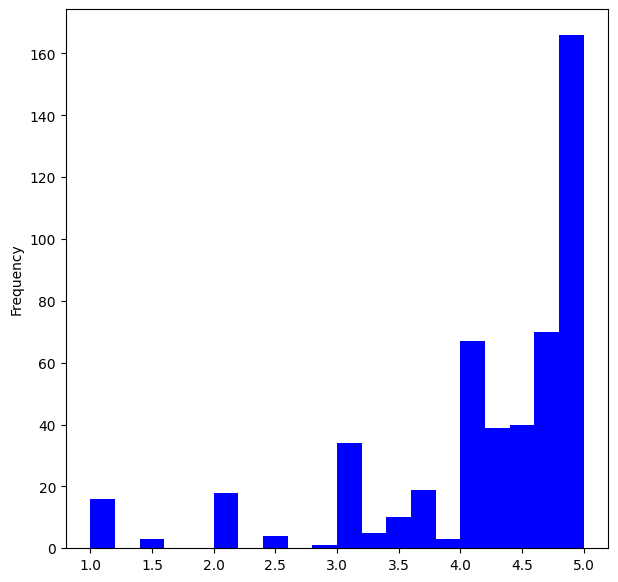

In [ ]:
data.groupby('length')['rating'].mean().plot.hist(color='blue',figsize=(7,7),bins=20)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')

words = cv.fit_transform(data.verified_reviews)

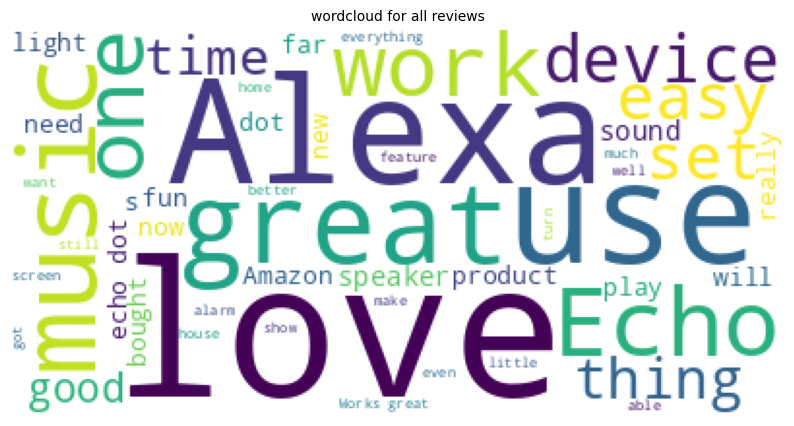

In [ ]:
reviews = " ".join([review for review in data['verified_reviews']])
wc = WordCloud(background_color='white', max_words=50)
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('wordcloud for all reviews',fontsize=10)
plt.axis('off')
plt.show()

In [ ]:
neg_reviews = " ".join([review for review in data[data['feedback']==0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()
pos_reviews = " ".join([review for review in data[data['feedback']==1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)
unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

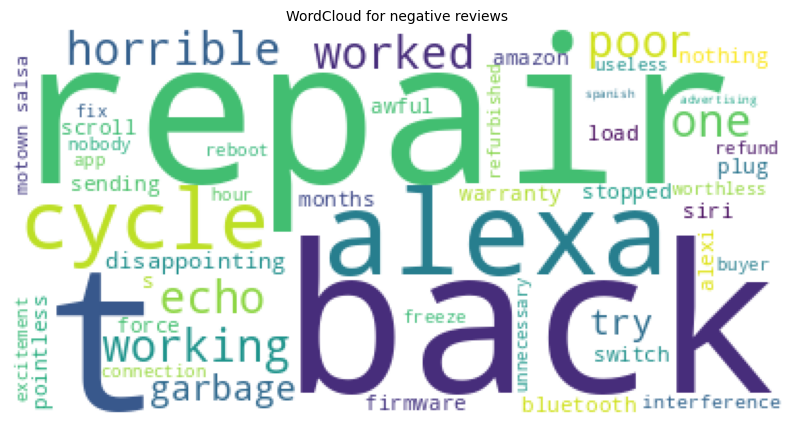

In [ ]:
wc = WordCloud(background_color='white', max_words=50)

plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('WordCloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

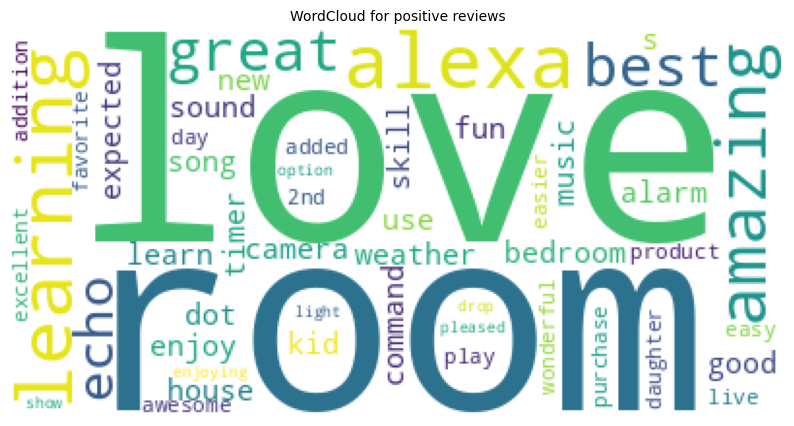

In [ ]:
wc = WordCloud(background_color='white', max_words=50)

plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('WordCloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

In [ ]:
corpus =[]
stemmer = PorterStemmer()
for i in range(0,data.shape[0]):
  review = re.sub('[^a-zA-Z]',' ', data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

In [ ]:


os.makedirs('Models', exist_ok=True)

cv = CountVectorizer(max_features = 2500)

X = cv.fit_transform(corpus).toarray()
Y = data['feedback'].values

with open('Models/countVectorizer.pkl', 'wb') as file:
    pickle.dump(cv, file)

In [ ]:
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")

X shape: (3149, 2500)
Y shape: (3149,)


In [ ]:


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=15)

print(f'X train: {X_train.shape}')
print(f'y train: {y_train.shape}')
print(f'X test: {X_test.shape}')
print(f'y test: {y_test.shape}')

X train: (2204, 2500)
y train: (2204,)
X test: (945, 2500)
y test: (945,)


In [ ]:
print(f"X train max value: {X_train.max()}")
print(f"X train min value: {X_test.max()}")

X train max value: 12
X train min value: 10


In [ ]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [ ]:
pickle.dump(scaler,open('Models/scaler.pk1','wb'))

In [ ]:
##RANDOM FOREST

model_rf=RandomForestClassifier()
model_rf.fit(X_train_scl,y_train)

RandomForestClassifier()

In [ ]:
print("training accuracy:",model_rf.score(X_train_scl,y_train)) # Use X_train_scl instead of X_test_scl for training accuracy
print("testing accuracy:",model_rf.score(X_test_scl,y_test))

training accuracy: 0.9945553539019963
testing accuracy: 0.9428571428571428


In [ ]:
y_preds=model_rf.predict(X_test_scl)

In [ ]:
cm=confusion_matrix(y_test,y_preds)

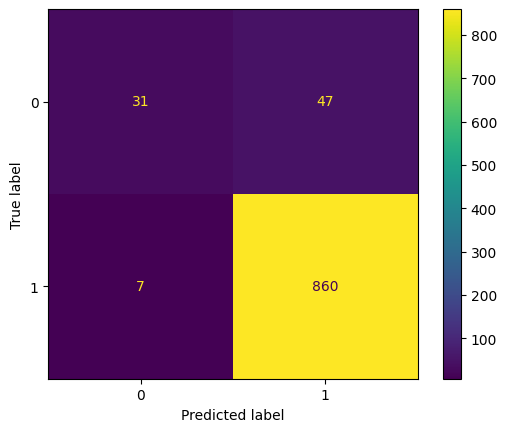

In [ ]:
cm_display=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()